In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as tfl
import pandas as pd
import zipfile

# Project Description
For this project, I am planning on using a facial data set from kaggle to identify facial features. This is very interesting to me, since it takes CNN models a step farther from binary classification. The goal will be to label X-Y coordinates for different facial features on unlabeled images. If the model is trained well then it can identify a face and its features from different angles.  This could be very useful in security cameras, identifying people in photos or videos and using the data to analyze facial expressions. This also has test data to submit to the competition.

### Kaggle Link 
https://www.kaggle.com/competitions/facial-keypoints-detection/overview

# Data 
The data is split into a training.csv and a test.csv. The training data has columns 0-29 for 30 facial features and the last column has the image data.  The test data just has image data. The image data is a single space delineated row of pixel values. I will reformat it to float32 and 96 x 96 x 1. I'll be splitting the training data into training and validation data to train my models. The first 30 columns are x or y coordinates for a facial feature. The 30 facial feature columns are all type float64 and the image is of size 96 x 96 X 1 (so they are greyscale).

In [2]:
#read data in
train_df = pd.read_csv('facial-keypoints-detection/training.csv')
test_df = pd.read_csv('facial-keypoints-detection/test.csv')

In [ ]:
print(train_df.head(3))

   left_eye_center_x  left_eye_center_y  right_eye_center_x  \
0          66.033564          39.002274           30.227008   
1          64.332936          34.970077           29.949277   
2          65.057053          34.909642           30.903789   

   right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
0           36.421678                59.582075                39.647423   
1           33.448715                58.856170                35.274349   
2           34.909642                59.412000                36.320968   

   left_eye_outer_corner_x  left_eye_outer_corner_y  right_eye_inner_corner_x  \
0                73.130346                39.969997                 36.356571   
1                70.722723                36.187166                 36.034723   
2                70.984421                36.320968                 37.678105   

   right_eye_inner_corner_y  ...  nose_tip_y  mouth_left_corner_x  \
0                 37.389402  ...   57.066803        

In [5]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

In [11]:
y_train = np.array(train_df.iloc[:,:30])

img_dt = []
for i in range(len(train_df)):
    img_dt.append(train_df['Image'][i].split(' '))

x_train = np.array(img_dt, dtype='float')

x_train = x_train.reshape(x_train.shape[0],96,96)

# Exploratory Data Analysis


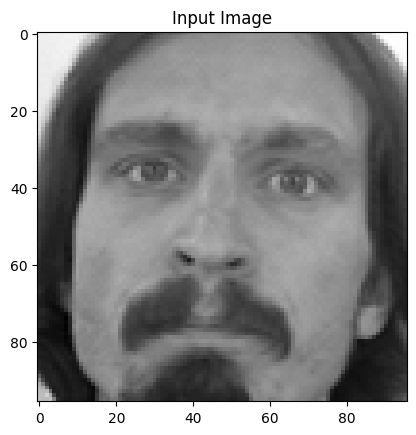

In [12]:
plt.imshow(x_train[0], cmap='gray')
plt.title("Input Image")
plt.savefig('plot.png', bbox_inches='tight')
plt.show()